In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [14]:
def plot_first_three_channels_spectrum(signal_df, subject, data_type, sampling_rate, max_frequency=50):
    """
    Plots the spectrum (FFT) of the first three channels (data from electrodes) of the EEG signal dataframe.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharey=True, tight_layout=True)

    for i in range(3):
        # Perform FFT
        signal = signal_df.iloc[:, i]
        n = len(signal)
        freq = np.fft.fftfreq(n, d=1/sampling_rate)
        spectrum = np.fft.fft(signal)
        
        # Filter the frequencies and spectrum to the max_frequency
        indices = np.where(freq >= 0)  # Only use non-negative frequencies
        freq = freq[indices]
        spectrum = np.abs(spectrum[indices])
        
        max_index = np.where(freq <= max_frequency)[0][-1]
        
        # Plot the magnitude spectrum
        axes[i].plot(freq[:max_index], spectrum[:max_index])
        axes[i].set_title(f"Channel {i+1} Spectrum")
        axes[i].set_xlabel('Frequency (Hz)')
        if i == 0:
            axes[i].set_ylabel('Magnitude')

    plt.suptitle(f"Subject {subject} - {data_type} EEG Signal Spectra (up to {max_frequency} Hz)", fontsize=16)

    plt.show()

In [3]:
def filter_signal(signal_df):
    """
    Filters the EEG signal using a Common Average Reference Filter (CAR)
    """

    # Calculate the average across all channels (columns) for each time point (row)
    average_signal = signal_df.mean(axis=1)
    
    # Subtract the average from each channel using broadcasting
    processed_signal_df = signal_df.sub(average_signal, axis=0)

    return processed_signal_df

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    """
    Design a bandpass filter using the Butterworth filter method
    """
    
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply a bandpass filter to the data
    """
    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
fs = 512 # Sampling frequency in Hz
lowcut_mu = 8
highcut_mu = 13
lowcut_beta = 13
highcut_beta = 30
num_subjects = 3

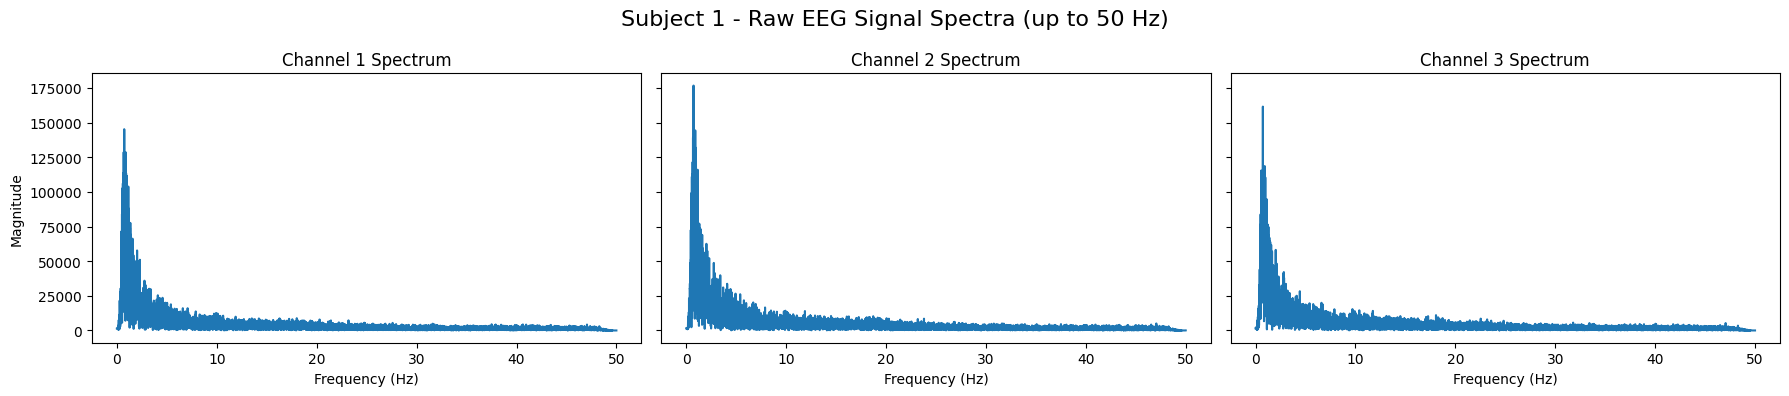

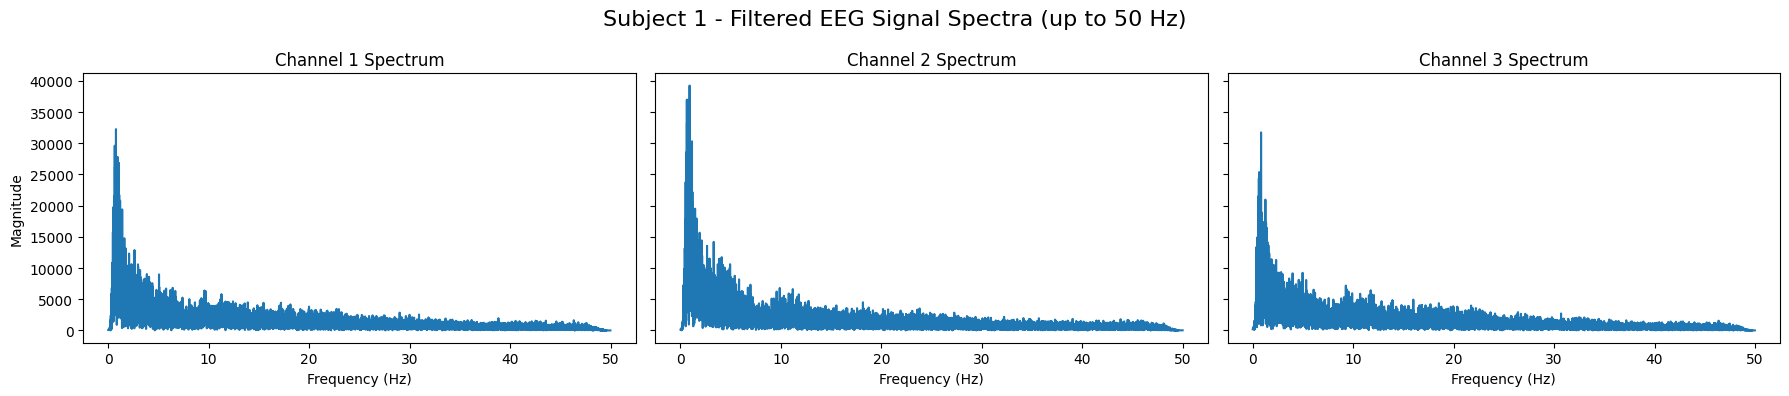

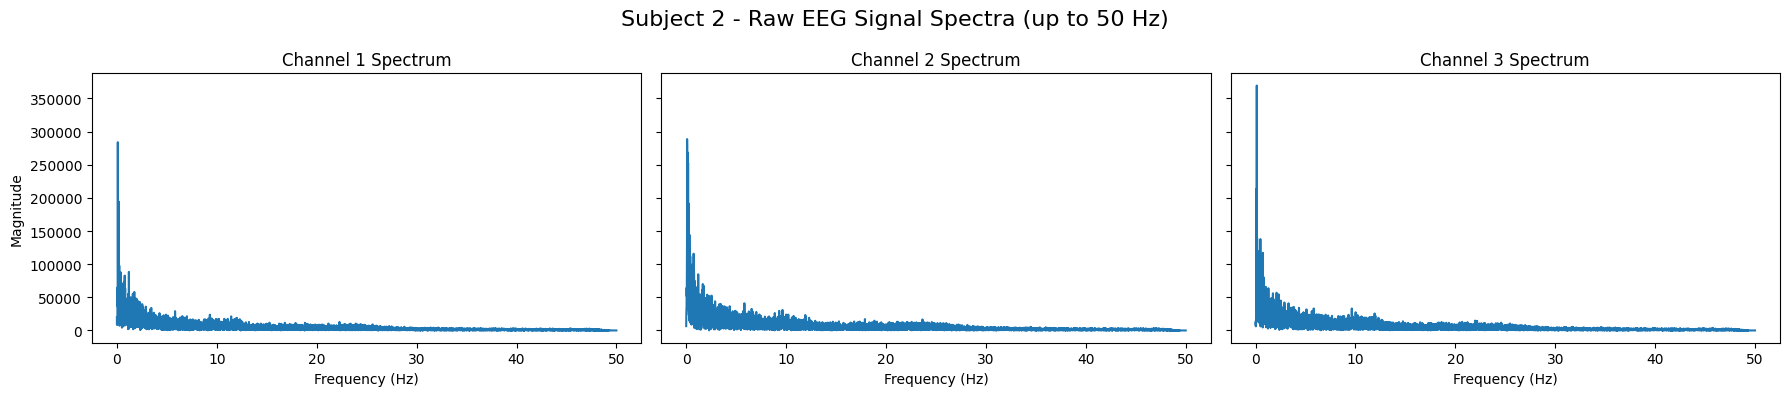

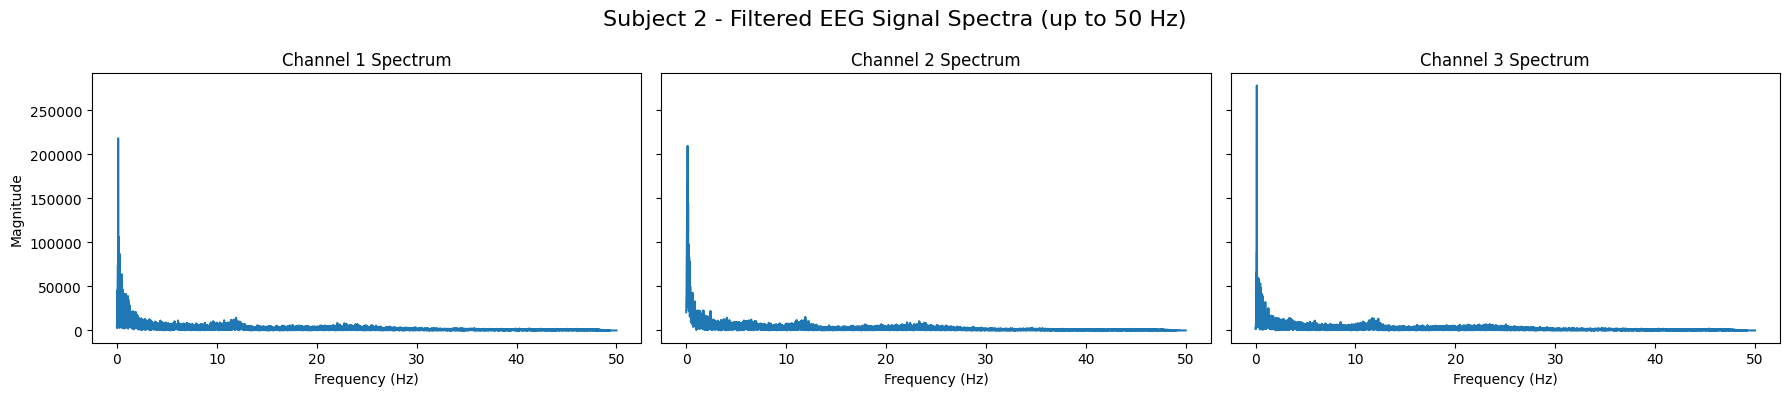

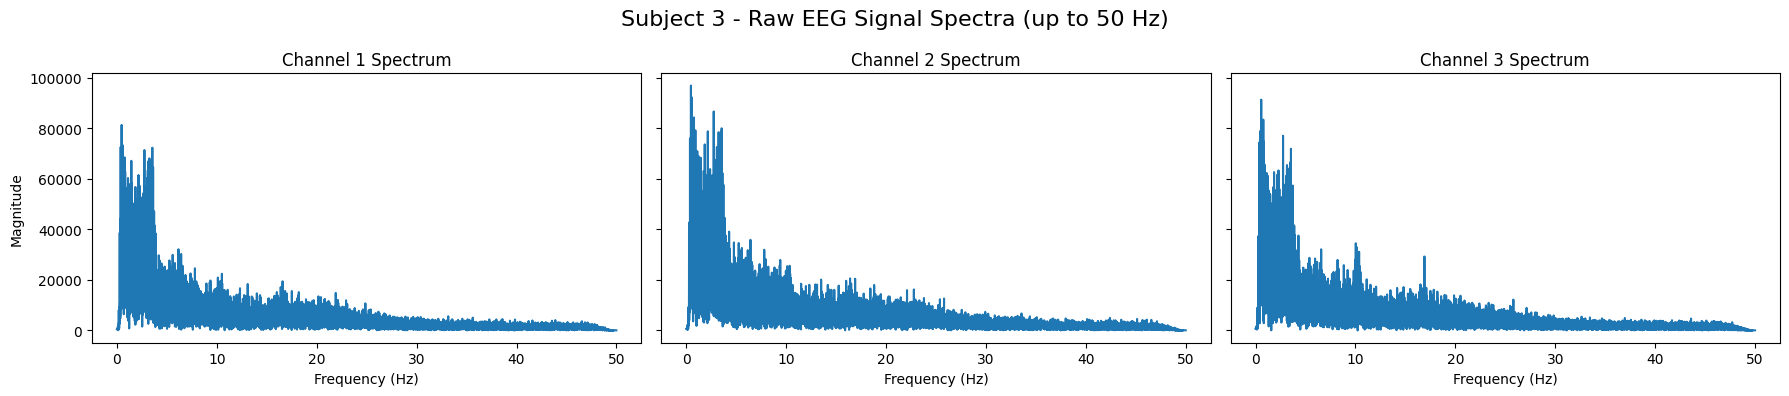

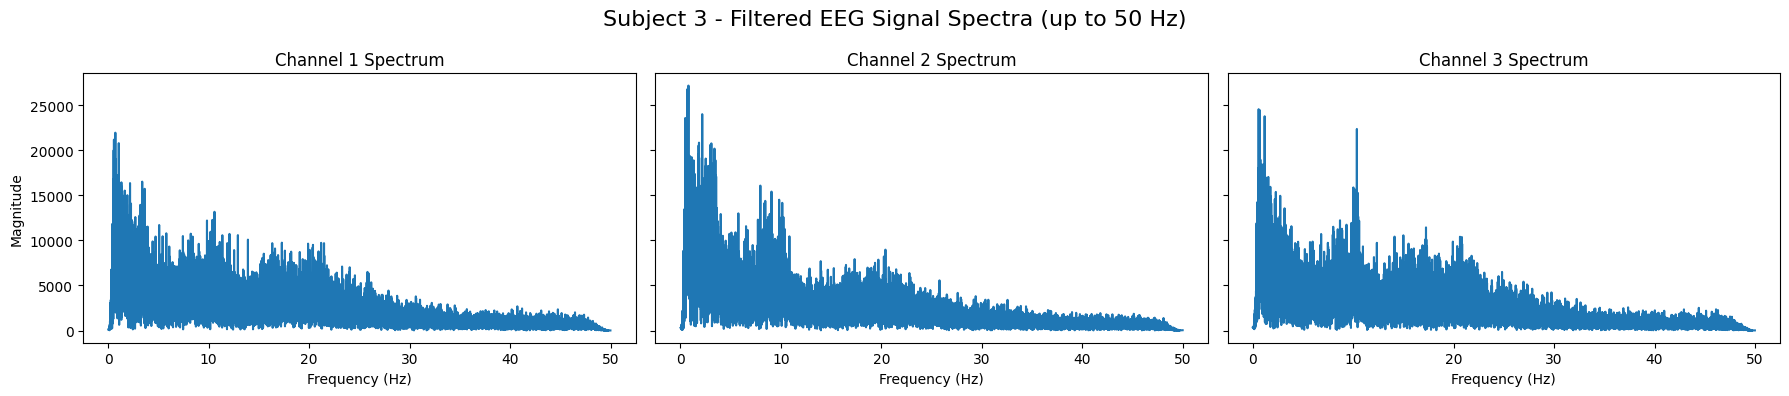

In [15]:
filtered_subjects = []

for subject in range(1, num_subjects+1):
    signals = pd.read_csv(f"../data/raw/subject_{subject}/Subject{subject}_Signals.csv")

    plot_first_three_channels_spectrum(signals, subject=subject, data_type="Raw", sampling_rate=fs)
    
    filtered_signals = filter_signal(signals)
    filtered_subjects.append(filtered_signals)
    filtered_signals.to_csv(f"../data/processed/subject_{subject}/Subject{subject}_Signals_CAR.csv", index=False)

    plot_first_three_channels_spectrum(filtered_signals, subject=subject, data_type="Filtered", sampling_rate=fs)

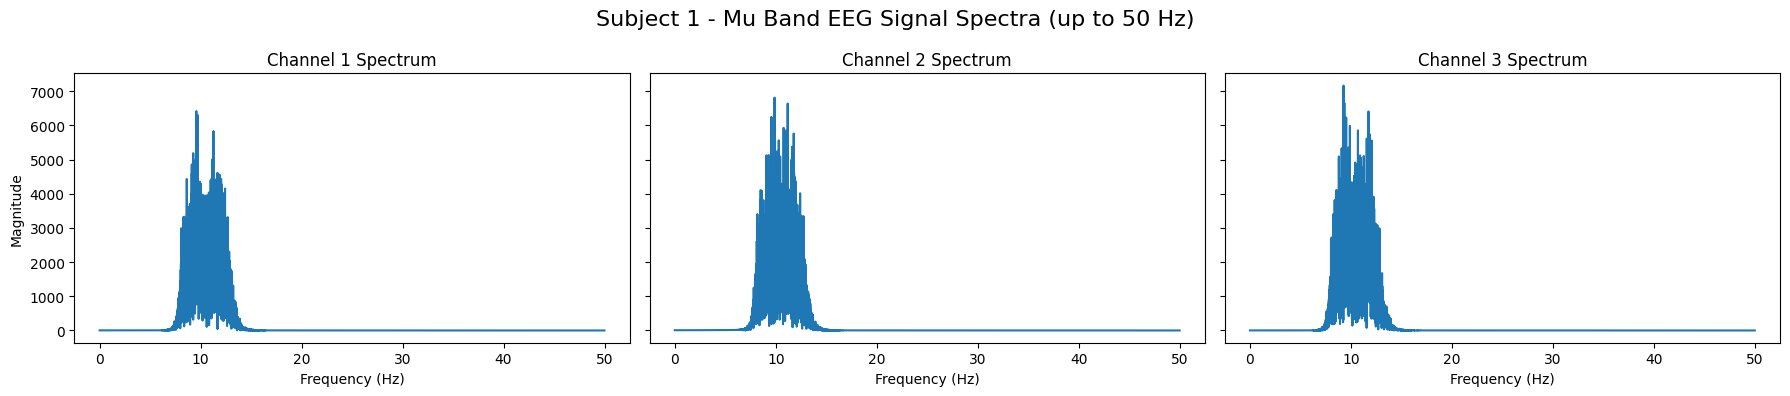

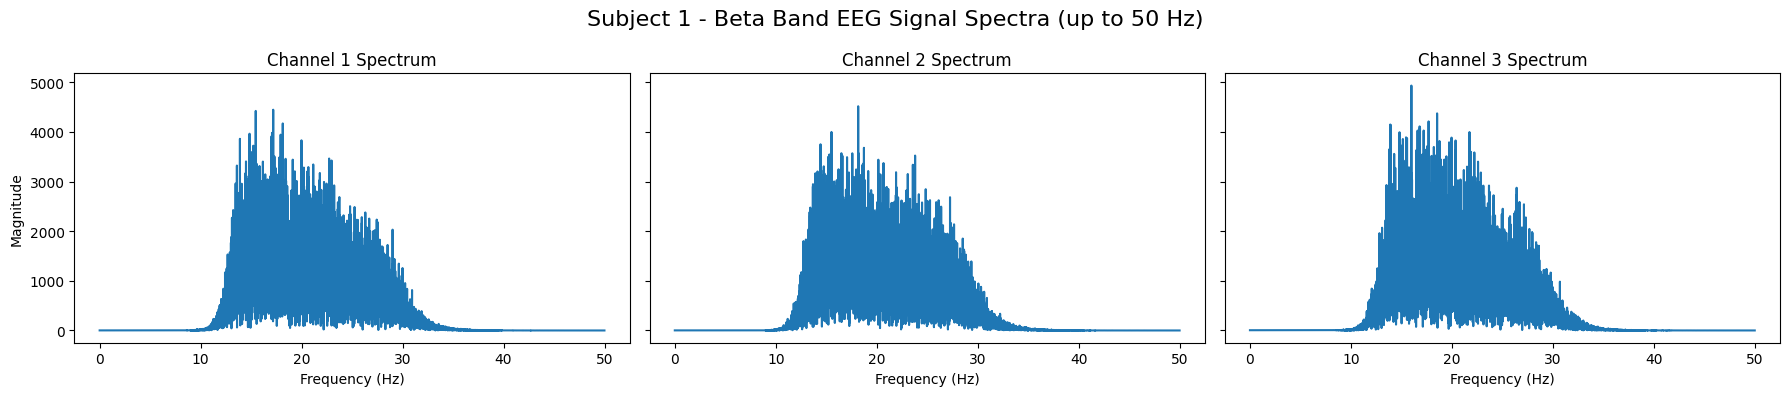

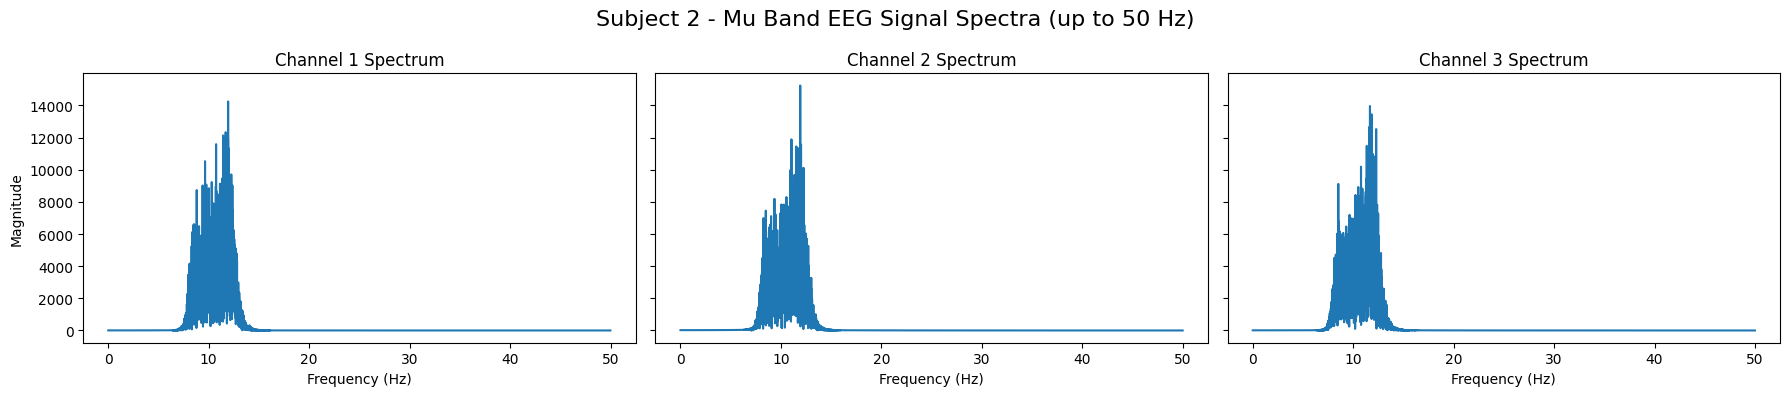

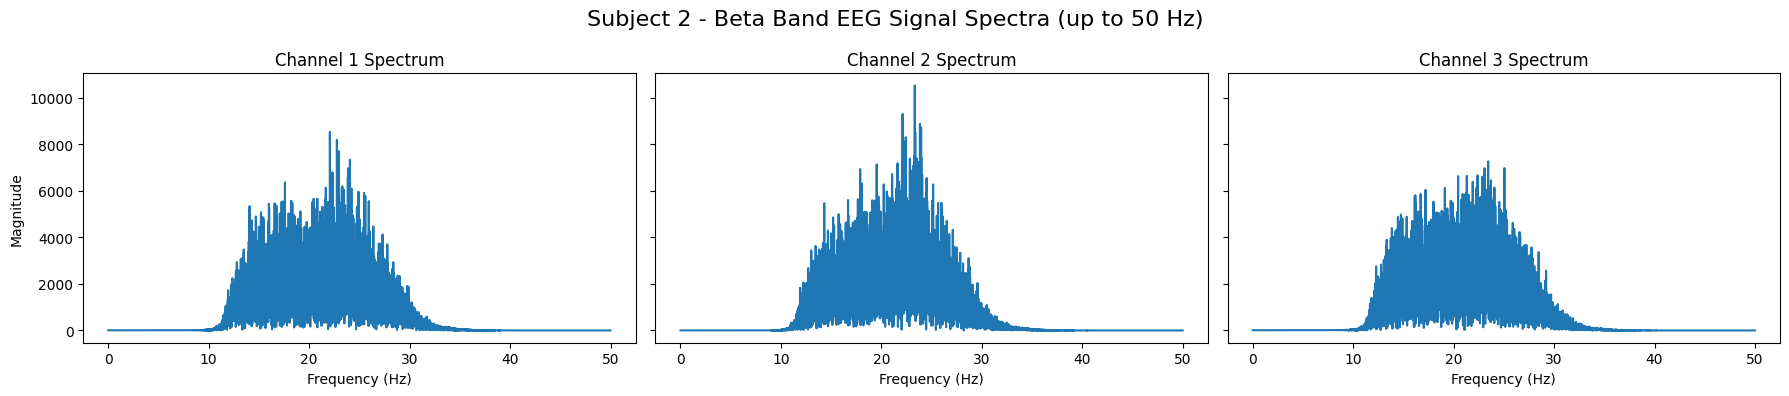

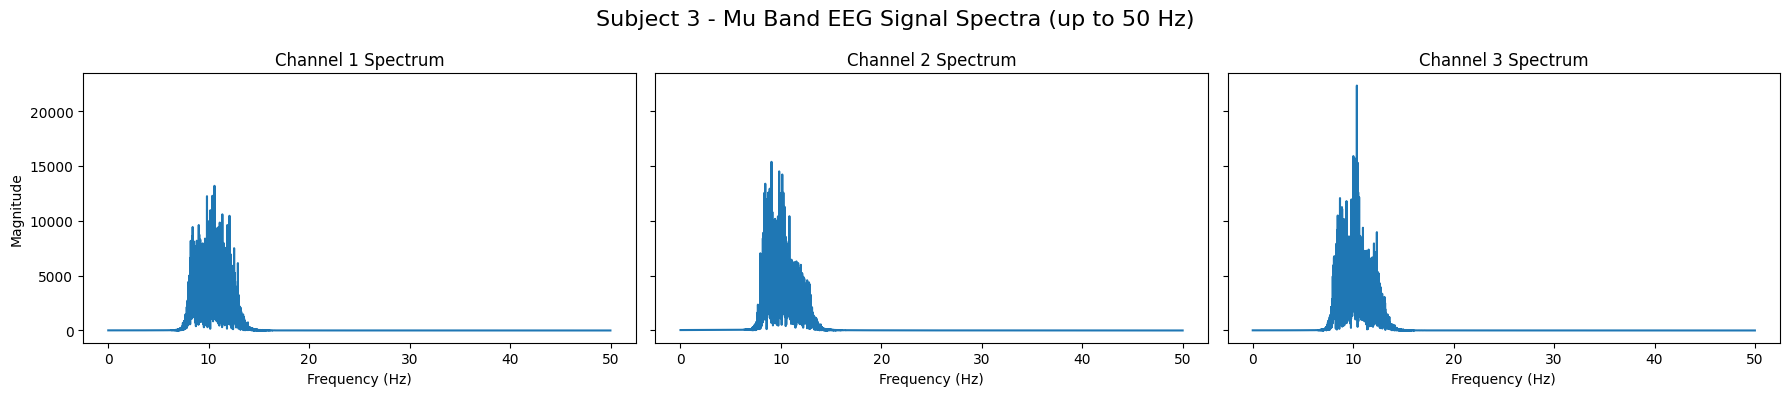

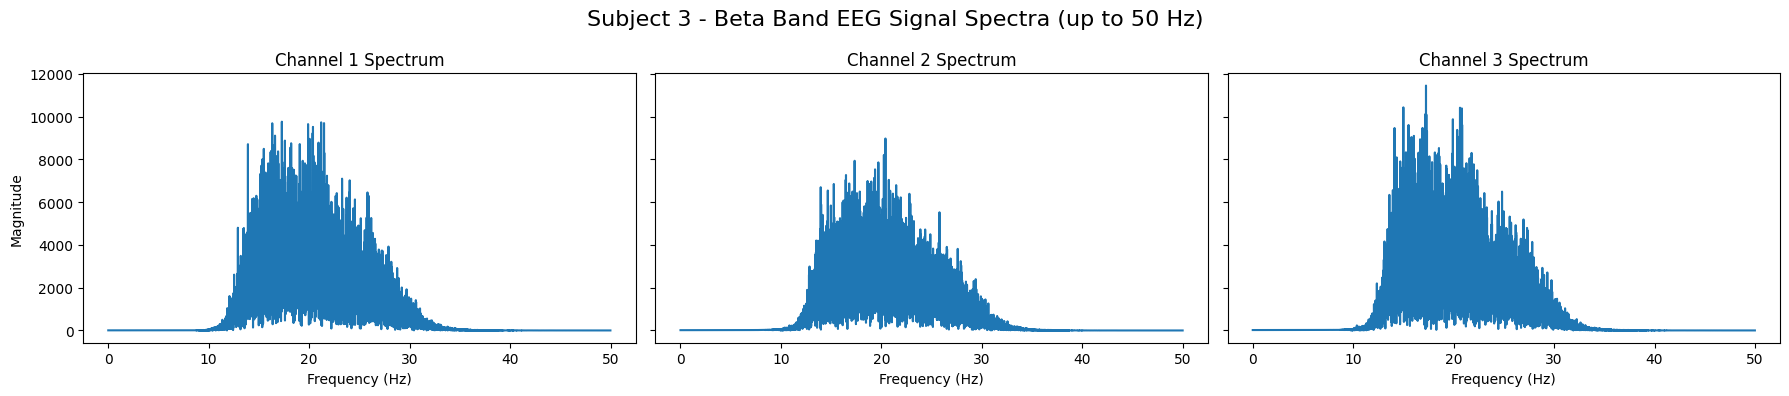

In [16]:
subjects_mu_band_data = []
subjects_beta_band_data = []

for subject, filtered_signals in enumerate(filtered_subjects, 1):
    mu_band_data = filtered_signals.apply(bandpass_filter, args=(lowcut_mu, highcut_mu, fs))
    subjects_mu_band_data.append(mu_band_data)
    mu_band_data.to_csv(f"../data/processed/subject_{subject}/Subject{subject}_Mu_Band.csv", index=False)

    plot_first_three_channels_spectrum(mu_band_data, subject=subject, data_type="Mu Band", sampling_rate=fs)

    beta_band_data = filtered_signals.apply(bandpass_filter, args=(lowcut_beta, highcut_beta, fs))
    subjects_beta_band_data.append(beta_band_data)
    beta_band_data.to_csv(f"../data/processed/subject_{subject}/Subject{subject}_Beta_Band.csv", index=False)

    plot_first_three_channels_spectrum(beta_band_data, subject=subject, data_type="Beta Band", sampling_rate=fs)
    